In [34]:
import glob
import os
import numpy as np

root_dir = 'CometImages/CA210609/Collated/'
all_dir = sorted(glob.glob(root_dir+'*'))
all_dir_simple = [os.path.basename(x) for x in sorted(glob.glob(all_dir[1]))]
#print(all_dir_simple)
#print(all_dir)
#print(str(all_dir[0]))
nDir = len(all_dir)
all_dir_edit = np.empty((nDir))
for n in range(0, nDir):
    cur_dir = [os.path.basename(x) for x in sorted(glob.glob(all_dir[n]))]
    print(cur_dir)
    print(type(cur_dir))
    all_dir_edit[n] = str(cur_dir)
print(all_dir_edit)

['1GyA']
<class 'list'>


ValueError: could not convert string to float: "['1GyA']"

In [59]:
import glob
import os
import sys
import numpy as np
import scipy.ndimage as scimg
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
# 
#################################################
# Read in bmp files in directory
#
convert = True
channel = '/DAPI'
#real_test_dir = '../../datasets/comet/test/*.bmp'  #where the test directory is comapred to this notebook location
root_dir = 'CometImages/IF210616/Collated/'
all_dir = sorted(glob.glob(root_dir+'*'))
print("all_dir: ",all_dir)
nDir = len(all_dir)
# loop over all directories
for nD in range(0, nDir):
    name_dir = [os.path.basename(x) for x in sorted(glob.glob(all_dir[nD]))]
    print("name_dir is: ", name_dir[0])
    #image_dir = all_dir[nD] + '/*.tif'  #where the image directory is - find all tif files here
    image_dir = all_dir[nD] + channel + '/*.tif'  #where the image directory is - find all tif files here
    print("image_dir is: ", image_dir)
    fileList= sorted(glob.glob(image_dir))  #whole file path, as set in above line
    print("Files read in (whole path) are", fileList)
    #
    fileNames = [os.path.basename(x) for x in sorted(glob.glob(image_dir))]  #only file name with extension
    #print("\nFile names (with extension) are:", fileNames)
    #
    nFiles = len(fileNames)
    print("\n",nFiles, " files will be analysed")
    #
    fileNamesSplit = np.empty((nFiles), dtype = 'object')


    for n in range (0, nFiles):
        x = fileNames[n]
        fileNamesSplit[n] = os.path.splitext(x)[0]   #remove extension from file name
    #print("fileNamesSplit is: ", fileNamesSplit)
    ##
    if convert==True:
        for n in range (0, nFiles):
            imgTif = Image.open(fileList[n], mode='r')
            imgArr = np.asarray(imgTif)
            outfile = all_dir[nD] + channel + '/bmp/' + name_dir[0] + '00' + str(n) + '.bmp'
            #outfile = root_dir + folder_dir +'/bmp/' + name_dir[0] + '00' +str(n)+ '.bmp'
            plt.imsave(outfile, imgArr)


print("complete")

all_dir:  ['CometImages/IF210616/Collated/1Gy', 'CometImages/IF210616/Collated/2Gy', 'CometImages/IF210616/Collated/4Gy', 'CometImages/IF210616/Collated/8Gy', 'CometImages/IF210616/Collated/Control']
name_dir is:  1Gy
image_dir is:  CometImages/IF210616/Collated/1Gy/DAPI/*.tif
Files read in (whole path) are ['CometImages/IF210616/Collated/1Gy/DAPI/img_000000000_DAPI_0001.tif', 'CometImages/IF210616/Collated/1Gy/DAPI/img_000000000_DAPI_00011.tif', 'CometImages/IF210616/Collated/1Gy/DAPI/img_000000000_DAPI_00013.tif', 'CometImages/IF210616/Collated/1Gy/DAPI/img_000000000_DAPI_00015.tif', 'CometImages/IF210616/Collated/1Gy/DAPI/img_000000000_DAPI_00017.tif', 'CometImages/IF210616/Collated/1Gy/DAPI/img_000000000_DAPI_00019.tif', 'CometImages/IF210616/Collated/1Gy/DAPI/img_000000000_DAPI_00021.tif', 'CometImages/IF210616/Collated/1Gy/DAPI/img_000000000_DAPI_00023.tif', 'CometImages/IF210616/Collated/1Gy/DAPI/img_000000000_DAPI_00025.tif', 'CometImages/IF210616/Collated/1Gy/DAPI/img_00000000


 30  files will be analysed
CometImages/CA210609/Collated/4GyB/img_000000000_SYBRGreen_000.tif


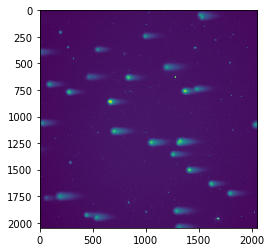

CometImages/CA210609/Collated/4GyB/img_000000000_SYBRGreen_0001.tif


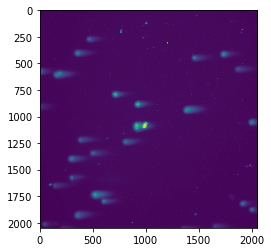

CometImages/CA210609/Collated/4GyB/img_000000000_SYBRGreen_00010.tif


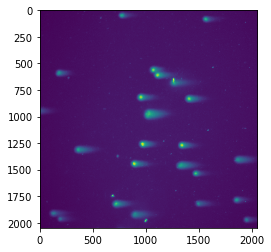

CometImages/CA210609/Collated/4GyB/img_000000000_SYBRGreen_00011.tif


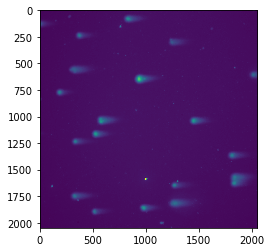

CometImages/CA210609/Collated/4GyB/img_000000000_SYBRGreen_00012.tif


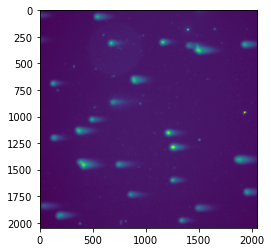

CometImages/CA210609/Collated/4GyB/img_000000000_SYBRGreen_00013.tif


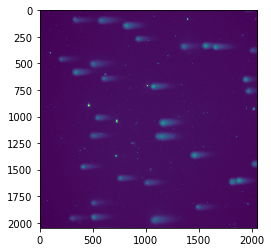

CometImages/CA210609/Collated/4GyB/img_000000000_SYBRGreen_00014.tif


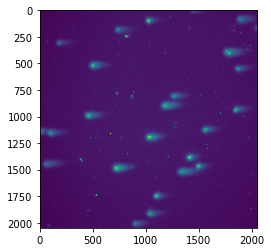

CometImages/CA210609/Collated/4GyB/img_000000000_SYBRGreen_00015.tif


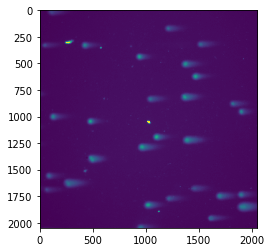

CometImages/CA210609/Collated/4GyB/img_000000000_SYBRGreen_00016.tif


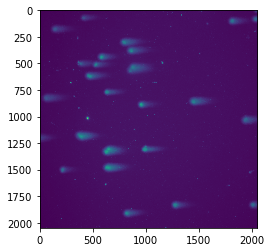

CometImages/CA210609/Collated/4GyB/img_000000000_SYBRGreen_00017.tif


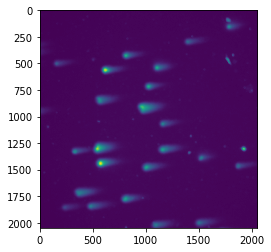

CometImages/CA210609/Collated/4GyB/img_000000000_SYBRGreen_00018.tif


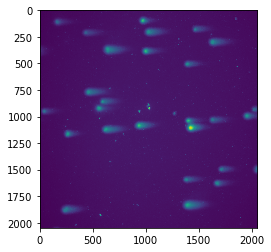

CometImages/CA210609/Collated/4GyB/img_000000000_SYBRGreen_00019.tif


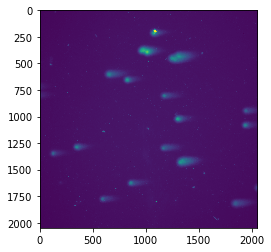

CometImages/CA210609/Collated/4GyB/img_000000000_SYBRGreen_0002.tif


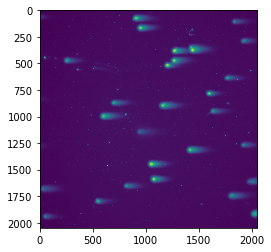

CometImages/CA210609/Collated/4GyB/img_000000000_SYBRGreen_00020.tif


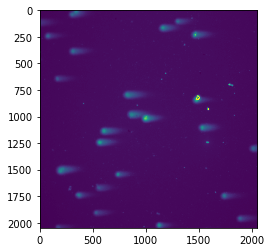

CometImages/CA210609/Collated/4GyB/img_000000000_SYBRGreen_00021.tif


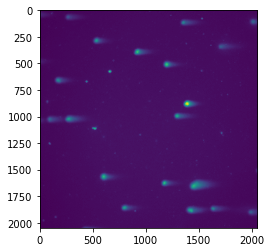

CometImages/CA210609/Collated/4GyB/img_000000000_SYBRGreen_00022.tif


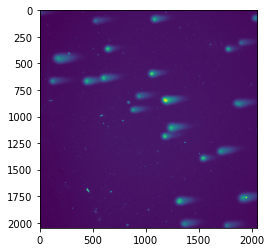

CometImages/CA210609/Collated/4GyB/img_000000000_SYBRGreen_00023.tif


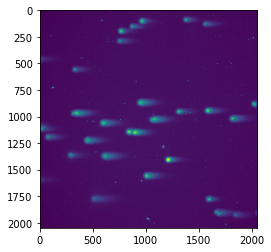

CometImages/CA210609/Collated/4GyB/img_000000000_SYBRGreen_00024.tif


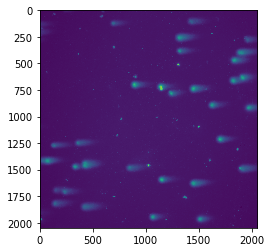

CometImages/CA210609/Collated/4GyB/img_000000000_SYBRGreen_00025.tif


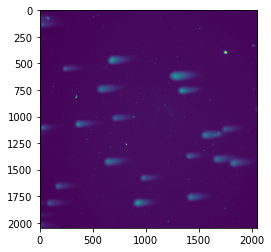

CometImages/CA210609/Collated/4GyB/img_000000000_SYBRGreen_00026.tif


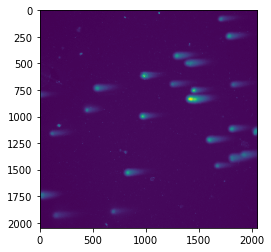

CometImages/CA210609/Collated/4GyB/img_000000000_SYBRGreen_00027.tif


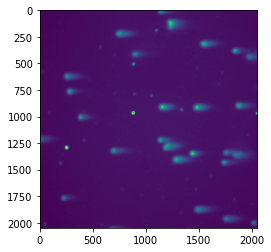

CometImages/CA210609/Collated/4GyB/img_000000000_SYBRGreen_00028.tif


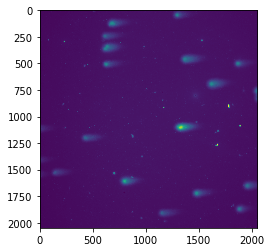

CometImages/CA210609/Collated/4GyB/img_000000000_SYBRGreen_00029.tif


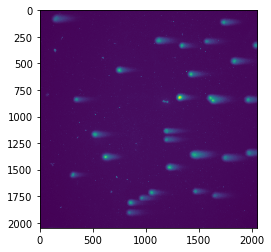

CometImages/CA210609/Collated/4GyB/img_000000000_SYBRGreen_0003.tif


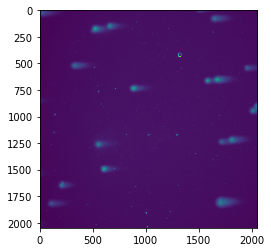

CometImages/CA210609/Collated/4GyB/img_000000000_SYBRGreen_0004.tif


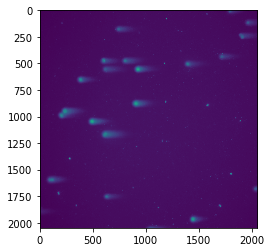

CometImages/CA210609/Collated/4GyB/img_000000000_SYBRGreen_0005.tif


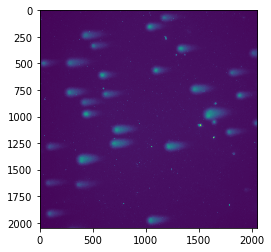

CometImages/CA210609/Collated/4GyB/img_000000000_SYBRGreen_0006.tif


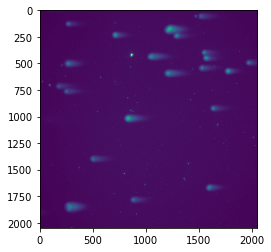

CometImages/CA210609/Collated/4GyB/img_000000000_SYBRGreen_0007.tif


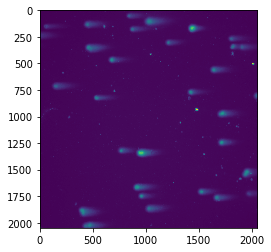

CometImages/CA210609/Collated/4GyB/img_000000000_SYBRGreen_0008.tif


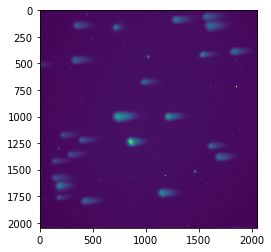

CometImages/CA210609/Collated/4GyB/img_000000000_SYBRGreen_0009.tif


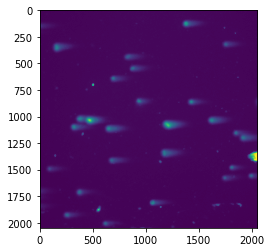

In [4]:
import numpy as np
import pickle
import os
import sys
import numpy as np
import scipy.ndimage as scimg
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import io
# 
#################################################
# Read in bmp files in directory
#
#real_test_dir = '../../datasets/comet/test/*.bmp'  #where the test directory is comapred to this notebook location
root_dir = 'CometImages/CA210609/Collated/'
image_dir = root_dir +'4GyB/*.tif'  #where the image directory is - find all bmp files here
fileList= sorted(glob.glob(image_dir))  #whole file path, as set in above line
#print("Files read in (whole path) are", fileList)
#
fileNames = [os.path.basename(x) for x in sorted(glob.glob(image_dir))]  #only file name with extension
#print("\nFile names (with extension) are:", fileNames)
#
nFiles = len(fileNames)
print("\n",nFiles, " files will be analysed")
#
fileNamesSplit = np.empty((nFiles), dtype = 'object')
for n in range (0, nFiles):
    x = fileNames[n]
    fileNamesSplit[n] = os.path.splitext(x)[0]   #remove extension from file name

for n in range(0, nFiles):
    # Load image
    print(fileList[n])
    im = io.imread(fileList[n])
    plt.imshow(im)
    plt.show()
    #ims = pickle.load(open(fileList[n], "rb"))

    # Normalise to range 0..255
    #norm = (ims.astype(np.float)-ims.min())*255.0 / (ims.max()-ims.min())

    outfile = root_dir +"1GyA/bmp/00"+str(n)+".bmp"
    # Save as 8-bit PNG
    Image.fromarray(im.astype(np.uint8)).save(outfile) 